In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.pipeline import Pipeline
import warnings
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Add the parent directory to the path to import custom utilities
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.dirname(notebook_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

# Import the feature selection score calculation utility
from utils import calculate_feature_selection_score

# Set visualization parameters
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'figure.titlesize': 18
})

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [14]:
def generate_synthetic_dataset(
    n_samples=1000,
    n_features=85,
    n_informative=5,
    n_redundant=20,
    n_correlated=15,
    random_state=42,
):
    """
    Generate a synthetic dataset for binary classification with customizable feature characteristics.
    
    Parameters:
    -----------
    n_samples : int, default=1000
        The number of samples to generate
    n_informative : int, default=5
        The number of informative features
    n_redundant : int, default=20
        The number of redundant features
    n_correlated : int, default=15
        The number of correlated features to generate
    n_classes : int, default=2
        The number of classes (only binary classification is fully supported)
    class_sep : float, default=1.0
        The class separation factor
    random_state : int, default=42
        Random seed for reproducibility
        
    Returns:
    --------
    X : pandas.DataFrame
        The feature matrix with named columns
    y : pandas.Series
        The target vector
    """
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    # Calculate the total base features (informative + redundant + noise)
    
    # Generate the base dataset
    X_base, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=0,
        n_classes=2,
        random_state=random_state,
        class_sep=1.0,
        shuffle=False
    )
    
    # Extract informative features for correlation creation
    informative_features = X_base[:, :n_informative]
    
    # Create correlated features
    correlated_features = np.zeros((X_base.shape[0], n_correlated))
    correlation_values = []
    
    # For each correlated feature, base it on one of the informative features
    for i in range(n_correlated):
        # Select a random informative feature to correlate with
        base_feature_idx = np.random.randint(0, n_informative)
        base_feature = informative_features[:, base_feature_idx]
        
        # Randomly choose whether correlation will be positive or negative
        if np.random.random() < 0.5:
            # Positive strong correlation (0.7 to 1.0)
            correlation_strength = 0.7 + (0.3 * np.random.random())
        else:
            # Negative strong correlation (-1.0 to -0.7)
            correlation_strength = -1.0 + (0.3 * np.random.random())

        correlation_values.append({
            'correlated_feature': f'correlated_{n_features+i}_to_{base_feature_idx}',
            'base_feature': f'informative_{base_feature_idx}',
            'correlation_strength': correlation_strength
        })

        noise_level = np.sqrt(1 - correlation_strength**2)
        
        # Generate the correlated feature
        noise = np.random.normal(0, 1, size=len(base_feature))
        correlated_feature = correlation_strength * base_feature + noise_level * noise
        
        # Standardize to maintain similar scale
        correlated_features[:, i] = StandardScaler().fit_transform(correlated_feature.reshape(-1, 1)).flatten()
    
    # Add the correlated features to X_base
    X_with_correlated = np.hstack((X_base, correlated_features))
    
    # Create descriptive feature names based on the feature type
    feature_names = []
    
    # Informative features
    for i in range(n_informative):
        feature_names.append(f'informative_{i}')
    
    # Redundant features
    for i in range(n_informative, n_informative + n_redundant):
        feature_names.append(f'redundant_{i}')
    
    # Noise features
    for i in range(n_informative + n_redundant, n_features):
        feature_names.append(f'noise_{i}')
    
    # Correlated features
    for i in range(n_correlated):
        base_feature_idx = correlation_values[i]['base_feature'].split('_')[1]
        feature_names.append(f'correlated_{n_features+i}_to_{base_feature_idx}')
        
    # Create final DataFrame and Series
    X_df = pd.DataFrame(X_with_correlated, columns=feature_names)
    y_df = pd.Series(y, name='target')
    
    return X_df, y_df, pd.DataFrame(correlation_values)

In [7]:
# Function to evaluate classifier performance
def evaluate_classifier(model, X_train, X_test, y_train, y_test, feature_names=None):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Create a results dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    # If feature_names are provided, add feature importance for Random Forest
    if feature_names is not None and isinstance(model, RandomForestClassifier):
        feature_importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        results['feature_importances'] = feature_importances.head(10)  # Top 10 features
    
    return results

# Feature selection techniques
# 1. Filter Method: SelectKBest with ANOVA F-statistic
def select_features_filter(X_train, y_train, X_test, k=5):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get the selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    return X_train_selected, X_test_selected, selected_features

# 2. Wrapper Method: Recursive Feature Elimination (RFE) with RF
def select_features_wrapper(X_train, y_train, X_test, k=5):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(estimator=model, n_features_to_select=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get the selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    return X_train_selected, X_test_selected, selected_features

# 3. Embedded Method: Random Forest with built-in feature importance
def select_features_embedded(X_train, y_train, X_test, k=5):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Select top k features
    top_indices = indices[:k]
    
    # Get the selected feature names
    selected_features = X_train.columns[top_indices].tolist()
    
    # Return the transformed datasets
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]
    
    return X_train_selected, X_test_selected, selected_features

In [35]:
from tqdm import tqdm
# Evaluate feature selection quality for different K values

# Define the range of K values to test
k_values = range(5, 51, 5)
n_datasets = 5
n_samples = 500
n_features = 85
n_informative = 5 
n_redundant = 20
n_correlated = 15

# Initialize dictionaries to store results for each method across all datasets
all_filter_scores = {k: [] for k in k_values}
all_wrapper_scores = {k: [] for k in k_values}
all_embedded_scores = {k: [] for k in k_values}
    
all_filter_features = {k: [] for k in k_values}
all_wrapper_features = {k: [] for k in k_values}
all_embedded_features = {k: [] for k in k_values}

# Run evaluation for each dataset
for dataset_idx in tqdm(range(n_datasets), desc="Iterating over datasets"):
    # Generate a new dataset with the same parameters but different random seed
    X, y, correlation_info = generate_synthetic_dataset(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_correlated=n_correlated,
        random_state=dataset_idx  # Use dataset index as random seed
    )
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Determine which features are relevant (informative + correlated) vs irrelevant
    all_relevant_features = [col for col in X.columns if 'informative_']
    all_irrelevant_features = [col for col in X.columns if 'noise_' in col or 'redundant_' in col or 'correlated_' in col]
    
    # For each K value, perform feature selection and evaluate quality
    for k in tqdm(k_values, desc=f"Different K values for dataset {dataset_idx+1}"):
        # Filter method
        _, _, filter_features = select_features_filter(X_train, y_train, X_test, k=k)
        filter_score = calculate_feature_selection_score(
            filter_features, 
            all_relevant_features, 
            all_irrelevant_features
        )
        all_filter_scores[k].append(filter_score)
        
        # Wrapper method
        _, _, wrapper_features = select_features_wrapper(X_train, y_train, X_test, k=k)
        wrapper_score = calculate_feature_selection_score(
            wrapper_features, 
            all_relevant_features, 
            all_irrelevant_features
        )
        all_wrapper_scores[k].append(wrapper_score)
        
        # Embedded method
        _, _, embedded_features = select_features_embedded(X_train, y_train, X_test, k=k)
        embedded_score = calculate_feature_selection_score(
            embedded_features, 
            all_relevant_features, 
            all_irrelevant_features
        )
        all_embedded_scores[k].append(embedded_score)

        all_filter_features[k].append(filter_features)
        all_wrapper_features[k].append(wrapper_features)
        all_embedded_features[k].append(embedded_features)

Iterating over datasets: 100%|██████████| 5/5 [15:15<00:00, 183.10s/it]


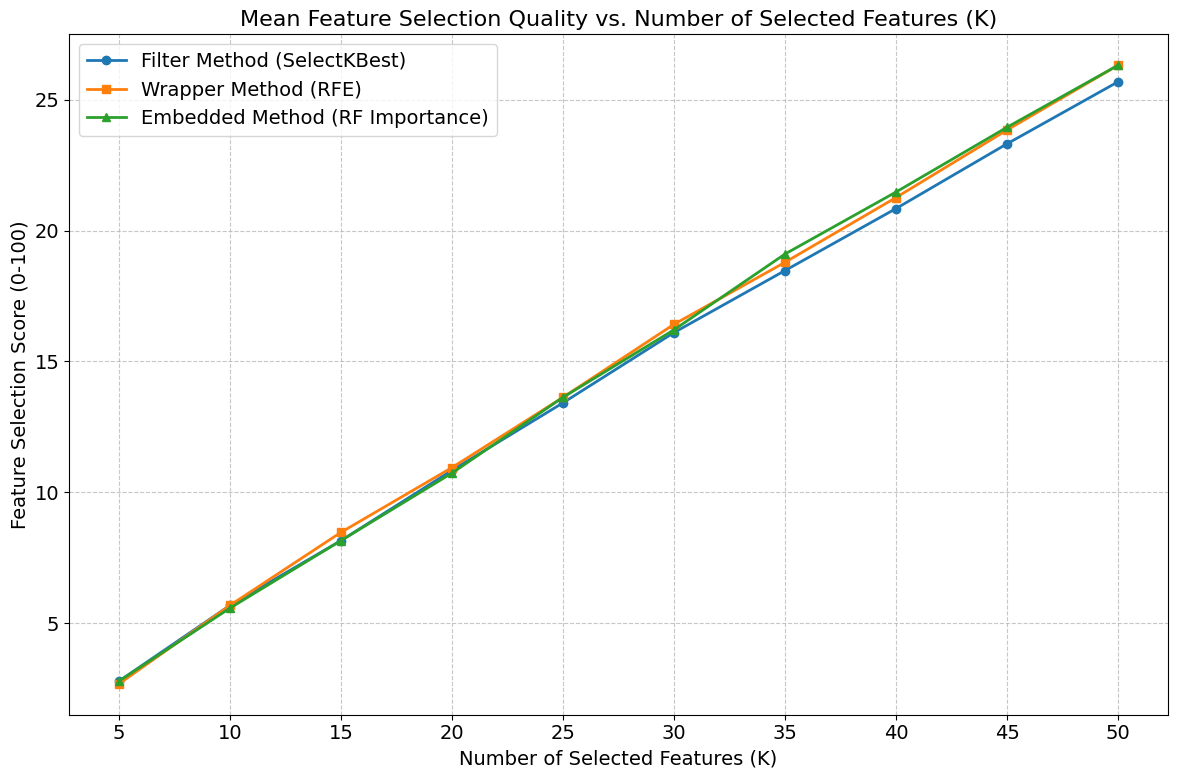

In [36]:
# Calculate mean scores across all datasets
mean_filter_scores = [np.mean(all_filter_scores[k]) for k in k_values]
mean_wrapper_scores = [np.mean(all_wrapper_scores[k]) for k in k_values]
mean_embedded_scores = [np.mean(all_embedded_scores[k]) for k in k_values]

# Calculate standard deviations for error bars
std_filter_scores = [np.std(all_filter_scores[k]) for k in k_values]
std_wrapper_scores = [np.std(all_wrapper_scores[k]) for k in k_values]
std_embedded_scores = [np.std(all_embedded_scores[k]) for k in k_values]

# Plot the results
plt.figure(figsize=(12, 8))
plt.errorbar(k_values, mean_filter_scores, fmt='o-', capsize=5, 
             label='Filter Method (SelectKBest)', linewidth=2)
plt.errorbar(k_values, mean_wrapper_scores, fmt='s-', capsize=5, 
             label='Wrapper Method (RFE)', linewidth=2)
plt.errorbar(k_values, mean_embedded_scores, fmt='^-', capsize=5, 
             label='Embedded Method (RF Importance)', linewidth=2)

plt.title('Mean Feature Selection Quality vs. Number of Selected Features (K)')
plt.xlabel('Number of Selected Features (K)')
plt.ylabel('Feature Selection Score (0-100)')
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Feature Selection Quality Scores by Number of Features (K) - Averaged over 5 datasets:
    K  Filter Method (Mean)  Filter Method (Std)  Wrapper Method (Mean)  \
0   5                  2.79                 0.39                   2.68   
1  10                  5.68                 0.39                   5.68   
2  15                  8.16                 0.33                   8.47   
3  20                 10.84                 0.26                  10.95   
4  25                 13.42                 0.00                  13.63   
5  30                 16.11                 0.42                  16.42   
6  35                 18.47                 0.42                  18.79   
7  40                 20.84                 0.42                  21.26   
8  45                 23.32                 0.39                  23.84   
9  50                 25.68                 0.39                  26.32   

   Wrapper Method (Std)  Embedded Method (Mean)  Embedded Method (Std)  
0             

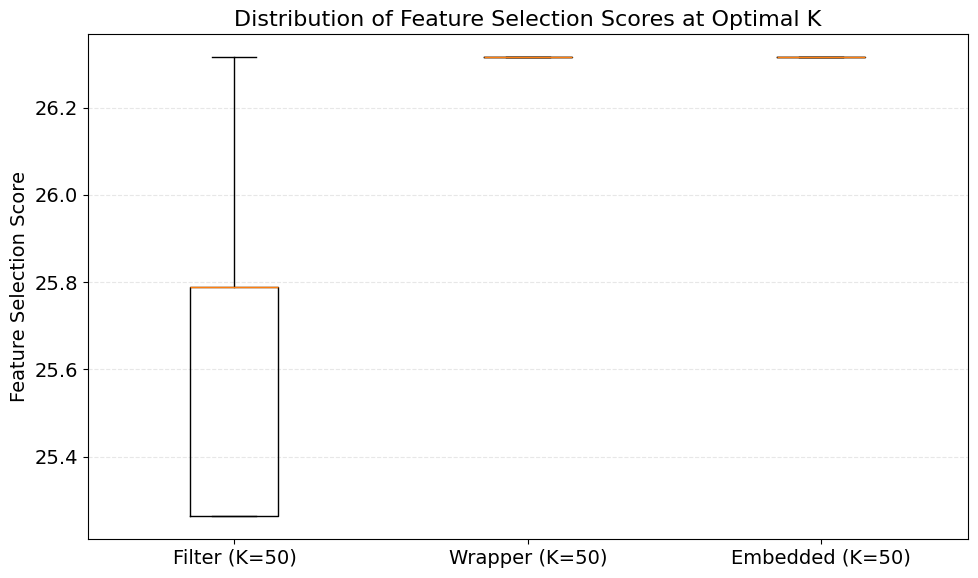

In [25]:
# Find and mark the best K value for each method
best_k_filter = k_values[mean_filter_scores.index(max(mean_filter_scores))]
best_k_wrapper = k_values[mean_wrapper_scores.index(max(mean_wrapper_scores))]
best_k_embedded = k_values[mean_embedded_scores.index(max(mean_embedded_scores))]

# Create a dataframe with the results
results_df = pd.DataFrame({
    'K': k_values,
    'Filter Method (Mean)': mean_filter_scores,
    'Filter Method (Std)': std_filter_scores,
    'Wrapper Method (Mean)': mean_wrapper_scores,
    'Wrapper Method (Std)': std_wrapper_scores,
    'Embedded Method (Mean)': mean_embedded_scores,
    'Embedded Method (Std)': std_embedded_scores
})

print("Feature Selection Quality Scores by Number of Features (K) - Averaged over 5 datasets:")
print(results_df.round(2))

# Print the optimal K values
print(f"\nBest K for Filter Method: {best_k_filter} (Mean Score: {max(mean_filter_scores):.2f} ± {std_filter_scores[mean_filter_scores.index(max(mean_filter_scores))]:.2f})")
print(f"Best K for Wrapper Method: {best_k_wrapper} (Mean Score: {max(mean_wrapper_scores):.2f} ± {std_wrapper_scores[mean_wrapper_scores.index(max(mean_wrapper_scores))]:.2f})")  
print(f"Best K for Embedded Method: {best_k_embedded} (Mean Score: {max(mean_embedded_scores):.2f} ± {std_embedded_scores[mean_embedded_scores.index(max(mean_embedded_scores))]:.2f})")

# Plot a box-and-whisker plot to show the distribution of scores for each method at their best K
plt.figure(figsize=(10, 6))

# Prepare data for boxplot
box_data = [
    all_filter_scores[best_k_filter],
    all_wrapper_scores[best_k_wrapper],
    all_embedded_scores[best_k_embedded]
]

plt.boxplot(box_data, labels=[
    f'Filter (K={best_k_filter})', 
    f'Wrapper (K={best_k_wrapper})', 
    f'Embedded (K={best_k_embedded})'
])

plt.title('Distribution of Feature Selection Scores at Optimal K')
plt.ylabel('Feature Selection Score')
plt.grid(True, linestyle='--', alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

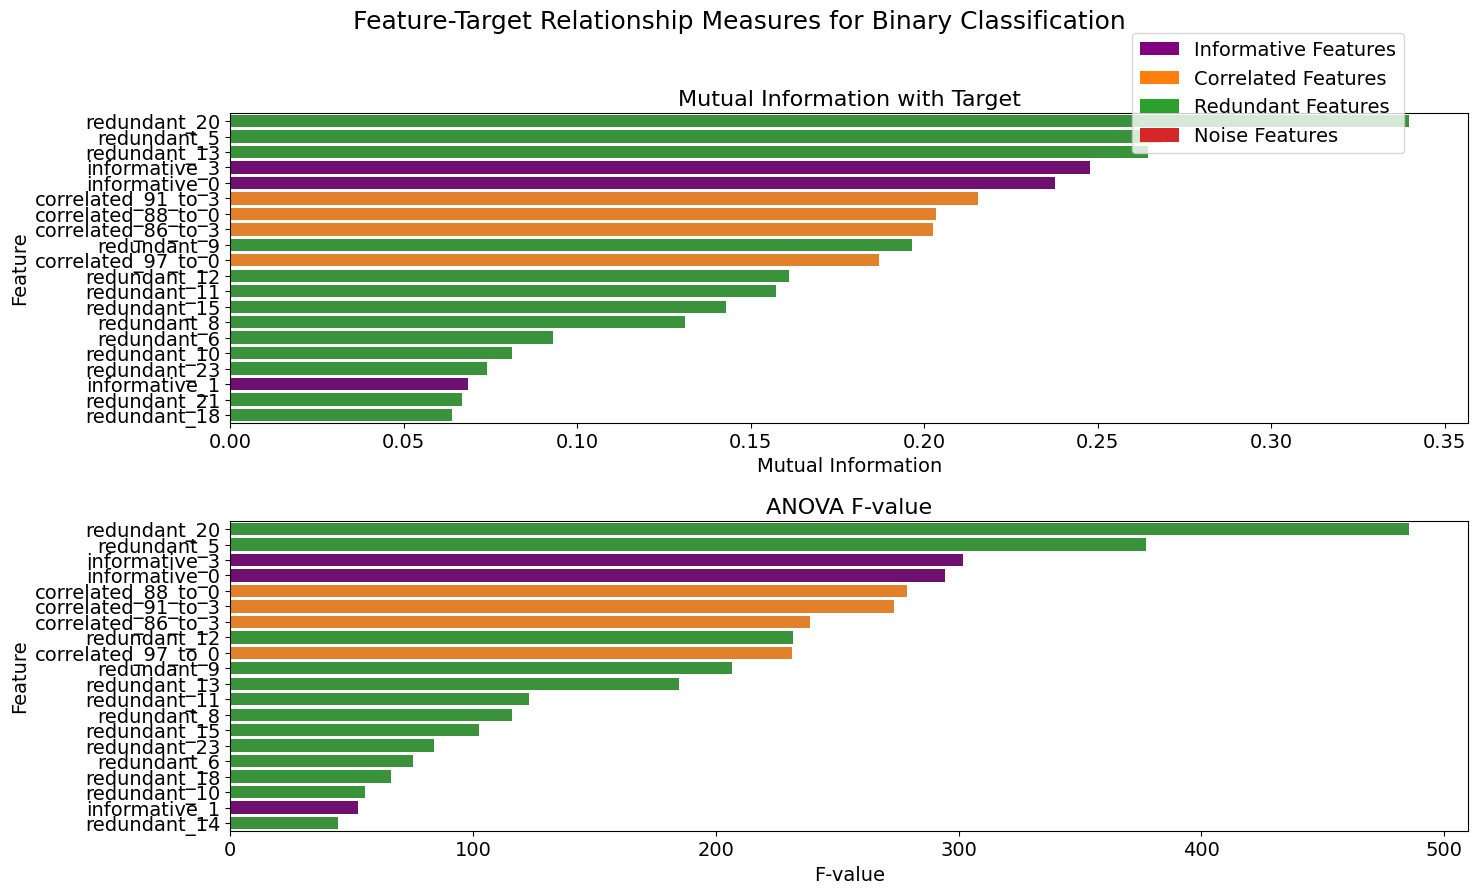


Top 10 features by Mutual Information:
1. redundant_20
2. redundant_5
3. redundant_13
4. informative_3
5. informative_0
6. correlated_91_to_3
7. correlated_88_to_0
8. correlated_86_to_3
9. redundant_9
10. correlated_97_to_0

Top 10 features by ANOVA F-value:
1. redundant_20
2. redundant_5
3. informative_3
4. informative_0
5. correlated_88_to_0
6. correlated_91_to_3
7. correlated_86_to_3
8. redundant_12
9. correlated_97_to_0
10. redundant_9

Feature type distribution in top features:
Mutual Information: {'informative': 2, 'correlated': 4, 'redundant': 4, 'noise': 0}
ANOVA F-value: {'informative': 2, 'correlated': 4, 'redundant': 4, 'noise': 0}


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy import stats

# Calculate different statistical measures for feature-target relationships
feature_stats = []
for col in X.columns:
    # Mutual Information (captures non-linear relationships)
    mi = mutual_info_classif(X[col].values.reshape(-1, 1), y, random_state=42)[0]
    
    # ANOVA F-value (measures class separability)
    f_val, _ = f_classif(X[col].values.reshape(-1, 1), y)
    
    feature_stats.append({
        'feature': col,
        'mutual_info': mi,
        'f_value': f_val[0]
    })

# Create dataframe with results
feature_stats_df = pd.DataFrame(feature_stats)

# Create color mapping for feature types
def assign_color(feature_name):
    if 'informative_' in feature_name:
        return 'purple'  # blue
    elif 'correlated_' in feature_name:
        return '#ff7f0e'  # orange
    elif 'redundant_' in feature_name:
        return '#2ca02c'  # green
    else:
        return '#d62728'  # red (noise)

# Create a figure with 3 subplots for each measurement
fig, axes = plt.subplots(2, 1, figsize=(15, 9))

# 2. Mutual Information
mi_df = feature_stats_df.sort_values('mutual_info', ascending=False).head(20)
colors = [assign_color(f) for f in mi_df['feature']]
sns.barplot(x='mutual_info', y='feature', data=mi_df, palette=colors, ax=axes[0])
axes[0].set_title('Mutual Information with Target', fontsize=16)
axes[0].set_xlabel('Mutual Information')
axes[0].set_ylabel('Feature')

# 3. ANOVA F-value
f_df = feature_stats_df.sort_values('f_value', ascending=False).head(20)
colors = [assign_color(f) for f in f_df['feature']]
sns.barplot(x='f_value', y='feature', data=f_df, palette=colors, ax=axes[1])
axes[1].set_title('ANOVA F-value', fontsize=16)
axes[1].set_xlabel('F-value')
axes[1].set_ylabel('Feature')

# Add legend to the figure
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='purple', label='Informative Features'),
    Patch(facecolor='#ff7f0e', label='Correlated Features'),
    Patch(facecolor='#2ca02c', label='Redundant Features'),
    Patch(facecolor='#d62728', label='Noise Features')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.98))

plt.suptitle('Feature-Target Relationship Measures for Binary Classification', fontsize=18, y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Create a summary table comparing top features across different measures
top_n = 10
top_features = {
    'Mutual Information': feature_stats_df.sort_values('mutual_info', ascending=False)['feature'].head(top_n).tolist(),
    'ANOVA F-value': feature_stats_df.sort_values('f_value', ascending=False)['feature'].head(top_n).tolist()
}

# Display the top features for each measure
for measure, features in top_features.items():
    print(f"\nTop {top_n} features by {measure}:")
    for i, feature in enumerate(features, 1):
        print(f"{i}. {feature}")

# Count feature types in top ranks for each measure
def count_feature_types(feature_list):
    counts = {'informative': 0, 'correlated': 0, 'redundant': 0, 'noise': 0}
    for feature in feature_list:
        if 'informative_' in feature:
            counts['informative'] += 1
        elif 'correlated_' in feature:
            counts['correlated'] += 1
        elif 'redundant_' in feature:
            counts['redundant'] += 1
        else:
            counts['noise'] += 1
    return counts

print("\nFeature type distribution in top features:")
for measure, features in top_features.items():
    counts = count_feature_types(features)
    print(f"{measure}: {counts}")